In [1]:
# Pip 安装命令
!pip install segmentation-models-pytorch -q
# !pip install lightning
!pip install wandb -U -q
!pip install monai  -q
!git clone https://github.com/by-liu/SegLossBias.git  -q
!pip install yacs  -q

# !pip install ipywidgets
# !pip install albumentations
# !pip install nibabel

import os
import sys

sys.path.append('/kaggle/working/SegLossBias')

In [2]:
import IPython

from matplotlib.patches import Patch, Rectangle
from IPython.display import display
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule

import matplotlib.pyplot as plt
# from fastai.losses import *
import torchmetrics
import wandb
# from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.core.mixins import HyperparametersMixin
from pytorch_lightning.callbacks import Callback

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

IPython.display.clear_output()

print("Envirionment Set Up.")

Envirionment Set Up.


# Dataset and Augment Setting

In [3]:
# 定义数据增强
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(),
    #     A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.3, alpha_affine=120 * 0.2),  # 以 0.3 的概率对图像进行弹性变形，模拟组织的弹性。
    A.RandomSizedCrop(min_max_height=(128, 256), height=256, width=256, p=0.3),  # 以 0.3 的概率随机裁剪图像的一部分。
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])


def adjust_window(image, window_center, window_width):
    """
    调整CT图像的窗宽窗位。
    :param image: 输入的图像数组。
    :param window_center: 窗位（WC）。
    :param window_width: 窗宽（WW）。
    :return: 调整窗宽窗位后的图像。
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    # print(windowed_img.dtype) # NOW its float64
    return windowed_img


class MultipleImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform  # transform: 应用于图像和标签的转换操作

    def __len__(self):
        # 假设图像和标签列表长度相等
        return len(self.image_paths)

    def __getitem__(self, idx):  # dataloader获取每个数据都会用到这个函数，所以你应当在这里实现你需要的
        # 预处理等等步骤
        image = (np.load(self.image_paths[idx]))['arr_0']
        #         print(image.shape)
        label = (np.load(self.label_paths[idx]))['arr_0']
        #         print(label.shape)

        image = adjust_window(image, window_center=40, window_width=400)

        if self.transform:
            #             image = image.astype(np.float32)
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            #             print("image aug")
            label = augmented['mask']
            image = image.float()
            label = label.long()

        label = label.long()
        image = (image - image.min()) / (image.max() - image.min())
        return image.float(), label.long()


class MOADataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 16):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        image_dir = os.path.join(self.data_dir, 'image_npz')  # 注意这里路径的更正
        label_dir = os.path.join(self.data_dir, 'mask_npz')

        # 读取文件路径
        image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.npz')])
        label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npz')])

        # 划分训练集、验证集、测试集
        train_size = int(0.8 * len(image_files))
        val_size = int(0.1 * len(image_files))

        self.train_image_paths = image_files[:train_size]
        self.val_image_paths = image_files[train_size:train_size + val_size]
        self.test_image_paths = image_files[train_size + val_size:]

        self.train_label_paths = label_files[:train_size]
        self.val_label_paths = label_files[train_size:train_size + val_size]
        self.test_label_paths = label_files[train_size + val_size:]

    def train_dataloader(self):
        train_dataset = MultipleImageDataset(self.train_image_paths, self.train_label_paths,
                                             transform=self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def val_dataloader(self):
        val_dataset = MultipleImageDataset(self.val_image_paths, self.val_label_paths, transform=self.val_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=1, pin_memory=True)

    def test_dataloader(self):
        test_dataset = MultipleImageDataset(self.test_image_paths, self.test_label_paths, transform=self.val_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=1, pin_memory=True)


# 定义数据集和数据加载器
old_data_dir = '/kaggle/input/rawniidataset/SMU_Dataset'
aug_data_dir = '/kaggle/input/aug-dataset-for-fine-tune/AUG_dataset'
data_dir = aug_data_dir

special_classes = [4, 5, 10, 12, 13]


def draw_bounding_boxes(ax, mask, class_ids):
    """ 在给定的轴上绘制边界框，突出显示特定类别 """
    special_classes = [4, 5, 10, 12, 13]
    for class_id in class_ids:
        positions = np.argwhere(mask == class_id)
        if positions.size > 0:
            xmin, xmax = positions[:, 0].min(), positions[:, 0].max()
            ymin, ymax = positions[:, 1].min(), positions[:, 1].max()
            rect = Rectangle((ymin, xmin), ymax - ymin, xmax - xmin, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(ymin, xmin, f'Class {class_id}', color='red', fontsize=12, va='top', ha='left')


def predict_and_log_images(num_samples=2):
    # 假设 test_loader 和 model 已经定义好了，并且 model 已经移动到了适当的设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = data_module.test_dataloader()

    # 生成随机索引
    indices = torch.randperm(len(test_loader.dataset))[:num_samples]

    # 调整subplot的大小
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))  # 每个样本显示3张图（原图、真实掩码、预测掩码）
    cmap = plt.get_cmap('tab20')  # 获取颜色映射
    for i, idx in enumerate(indices):
        image, mask = test_loader.dataset[idx]
        class_labels = np.unique(mask)  # 获取类别标签
        colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
        image = image.unsqueeze(0).to(device)  # 添加batch维度并移动到设备
        mask = mask.squeeze()  # 移除batch维度（如果有的话）

        with torch.no_grad():
            pred = model(image)
            prediction = torch.argmax(pred, dim=1).cpu()  # 获取预测类别并移回CPU

        # 显示原始图像
        axs[i, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original Image {i + 1}')
        axs[i, 0].axis('off')

        # 显示Ground Truth
        axs[i, 1].imshow(mask.cpu().numpy(), cmap='tab20')
        axs[i, 1].set_title(f'True Mask {i + 1}')
        axs[i, 1].axis('off')

        # 显示预测掩码
        axs[i, 2].imshow(prediction[0].numpy(), cmap='tab20')
        axs[i, 2].set_title(f'Predicted Mask {i + 1}')
        axs[i, 2].axis('off')

        # 在真实和预测掩码上绘制边界框
        draw_bounding_boxes(axs[i, 1], mask.cpu().numpy(), special_classes)
        draw_bounding_boxes(axs[i, 2], prediction[0].numpy(), special_classes)

    legend_elements = [Patch(facecolor=colors[i], label=f'Class {class_labels[i]}') for i in range(len(class_labels))]
    fig.legend(handles=legend_elements, loc='upper center', ncol=len(class_labels), title="Classes")
    plt.tight_layout()
    plt.close(fig)  # 防止在notebook中显示图像
    return fig


class ValidationCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        # 每10个epoch执行一次
        if (trainer.current_epoch + 1) % 2 == 0:  # 之前：%5
            fig = predict_and_log_images(num_samples=2)
            # 用wandb记录图像，或进行其他操作
            wandb.log({"Validation Callback Predicted Images": wandb.Image(fig)})

In [4]:
# 初始化数据模块
data_module = MOADataModule(data_dir=data_dir, batch_size=16)

# 设置数据模块（准备数据）
data_module.setup()

# (Opt) Data Pre-Check

Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [0 1 5 6 7 8 9]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [0 5 6 8 9]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [0 1 5 6 7 8 9]
Image shape: (256, 256)
Label shape: (256, 256)
Image M&m Value: (1.0, 0.0)
Label Unique: [ 0  1  2  3  4  6  7  8  9 10 11 12 13]


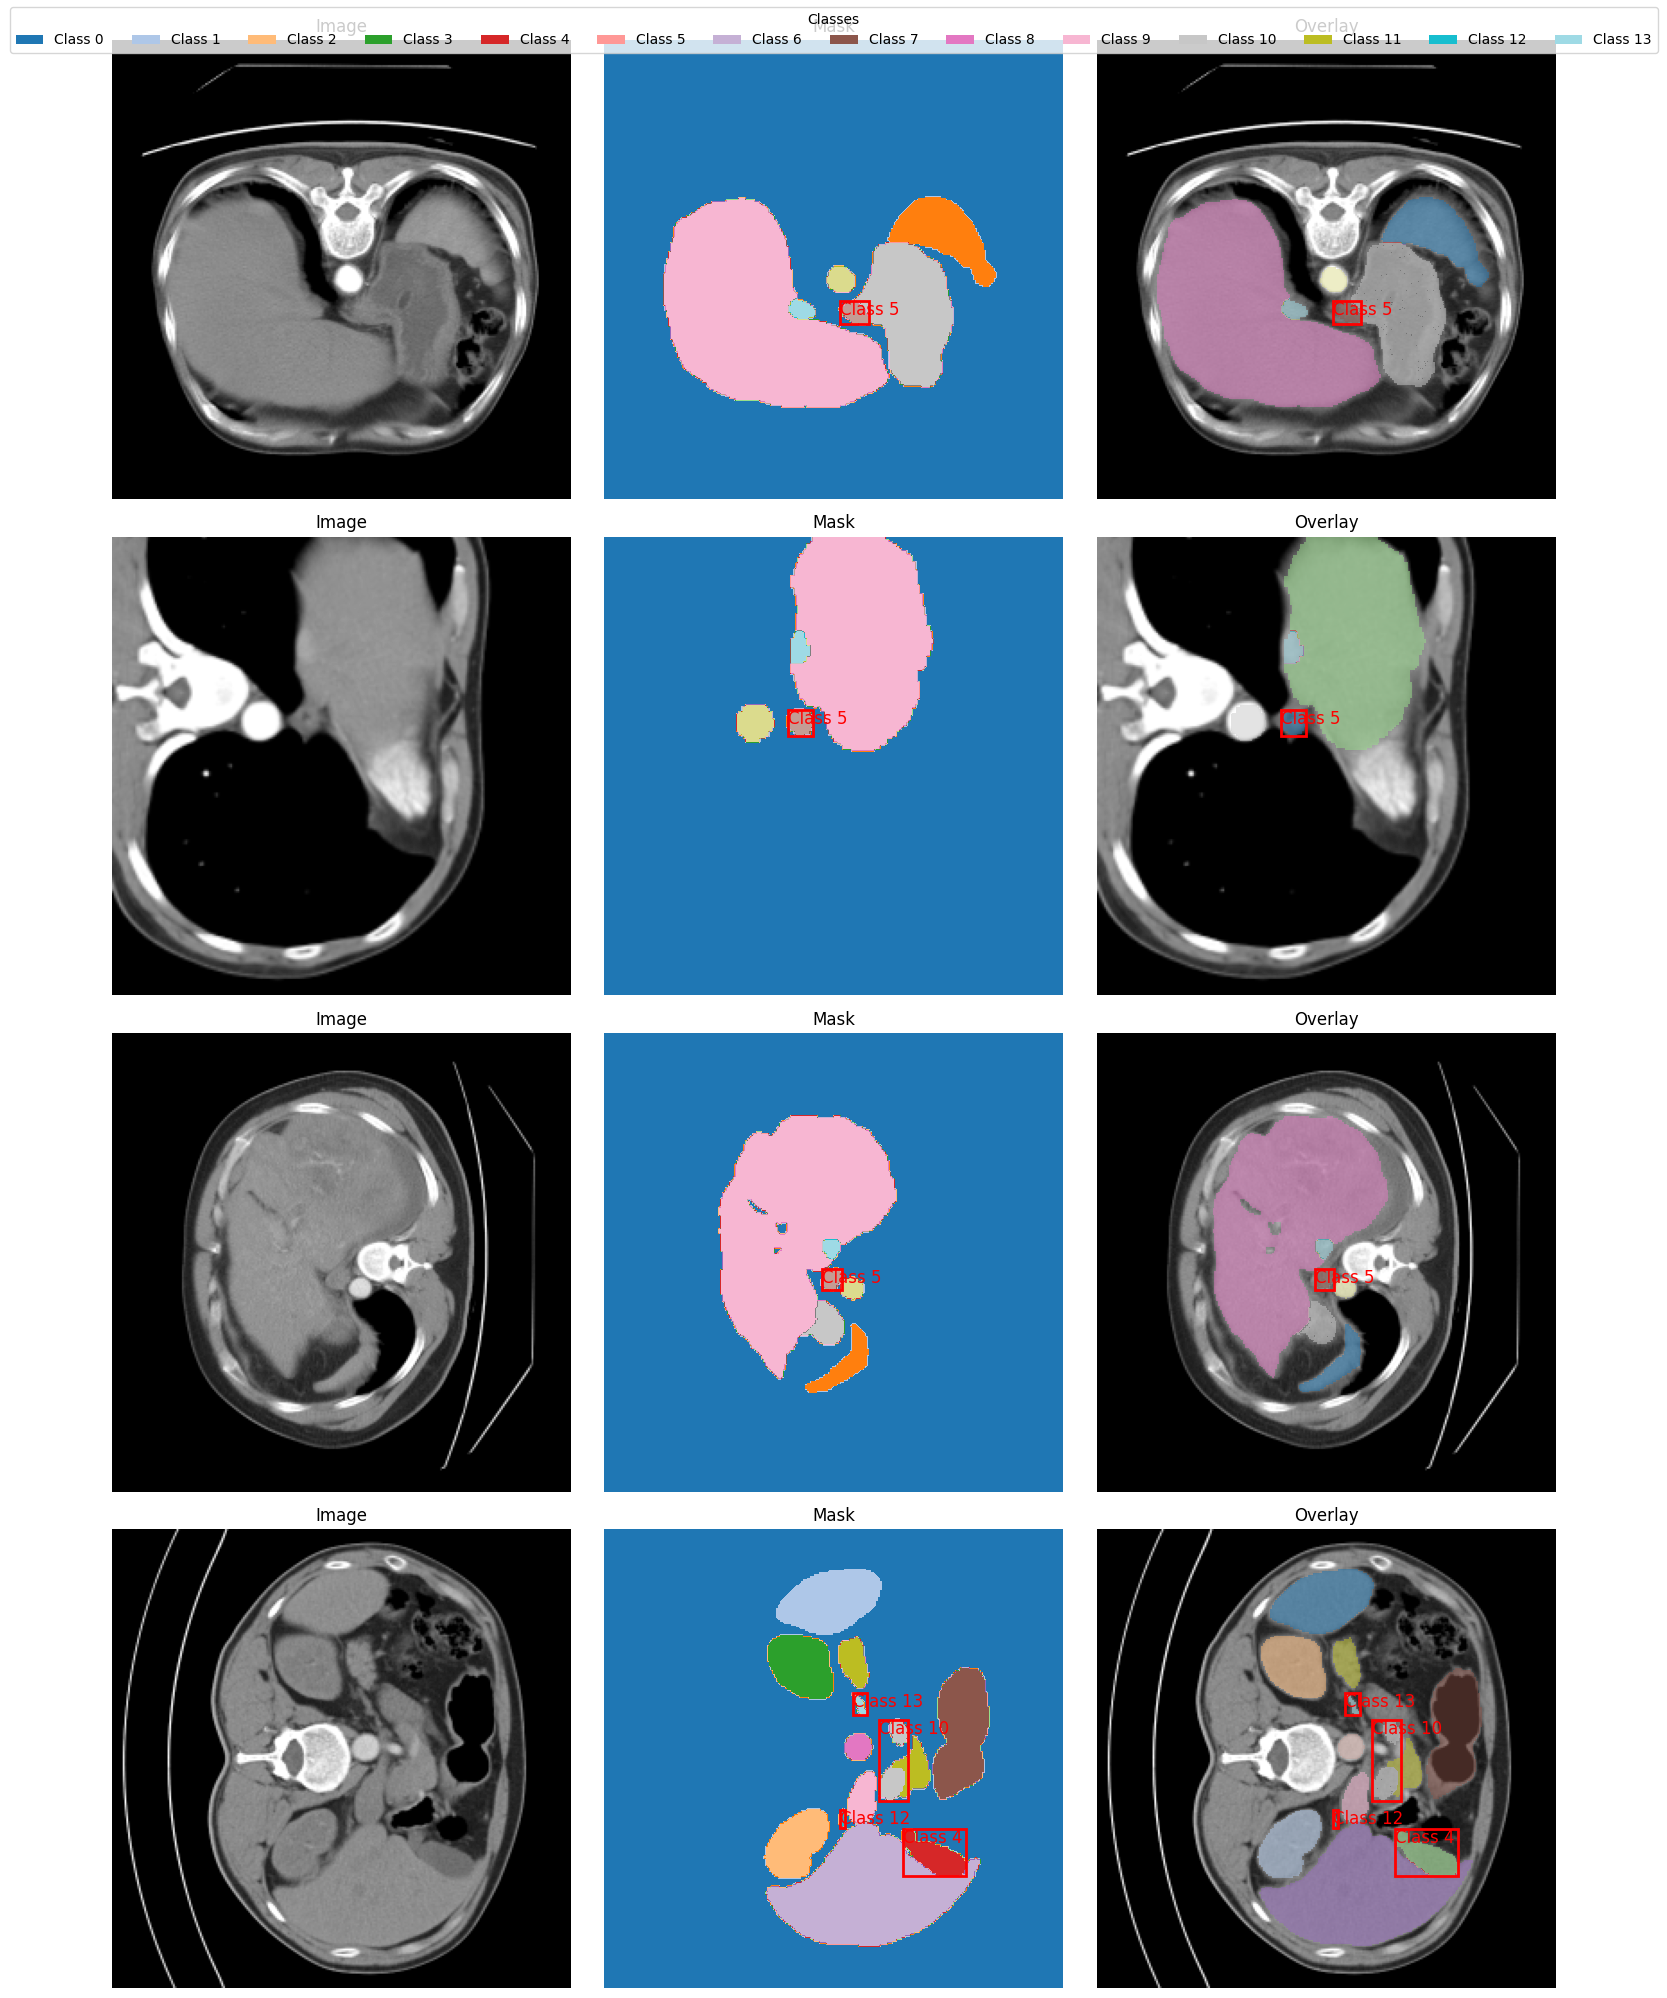

In [5]:
# 获取训练数据加载器
train_loader = data_module.train_dataloader()

# 从数据加载器中抽取一批数据
images, labels = next(iter(train_loader))

# 选择要展示的图像数量
num_images_to_show = 4

# 创建图表来展示图像和对应的掩码
fig, axs = plt.subplots(num_images_to_show, 3, figsize=(15, num_images_to_show * 5))
class_labels = np.unique(labels)  # 获取类别标签
cmap = plt.get_cmap('tab20')  # 获取颜色映射
colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]

for i in range(num_images_to_show):
    img = images[i].squeeze().numpy()  # 假设图像和掩码都只有一个通道
    lbl = labels[i].squeeze().numpy()
    overlay = np.ma.masked_where(lbl == 0, lbl)

    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')  # 关闭第一个子图轴的所有边框和刻度线

    axs[i, 1].imshow(lbl, cmap='tab20')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(img, cmap='gray')
    axs[i, 2].imshow(overlay, cmap='tab20', alpha=0.5)
    axs[i, 2].set_title('Overlay')
    axs[i, 2].axis('off')

    draw_bounding_boxes(axs[i, 1], lbl, special_classes)
    draw_bounding_boxes(axs[i, 2], overlay, special_classes)

    print(f"Image shape: {img.shape}")
    print(f"Label shape: {lbl.shape}")
    print(f"Image M&m Value: {img.max(), img.min()}")
    print(f"Label Unique: {np.unique(lbl)}")

legend_elements = [Patch(facecolor=colors[i], label=f'Class {class_labels[i]}') for i in range(len(class_labels))]
fig.legend(handles=legend_elements, loc='upper center', ncol=len(class_labels), title="Classes")

plt.tight_layout()
plt.show()

# Custom DiceCELossWithKL based on SegLossBias
https://github.com/by-liu/SegLossBias.git

In [6]:
from seglossbias.modeling.compound_losses import *
from monai.losses.dice import *
from torch.nn.modules.loss import _Loss


class DiceCELossWithKL(_Loss):  # 添加KL散度
    def __init__(
            self,
            mode: str = 'MULTICLASS_MODE',  # 用于设置Dice Loss和交叉熵的模式，支持'MULTICLASS_MODE' 和其他PyTorch DiceLoss支持的模式。
            include_background: bool = True,  # 是否将背景类包含在 Dice Loss 的计算中。
            to_onehot_y: bool = False,  # 是否将真实标签转换为 one-hot 编码。
            sigmoid: bool = False,  # 是否在计算 Dice  Loss 之前对预测输出应用 sigmoid 或 softmax 函数。
            softmax: bool = False,
            other_act: Callable | None = None,  # 可选的自定义激活函数。
            squared_pred: bool = False,  # 是否在计算 Dice Loss 之前将预测输出平方。
            jaccard: bool = False,  #  是否使用 Jaccard 指数替代 Dice 系数。
            reduction: str = "mean",  # 指定 Dice Loss 和交叉熵 Loss 的 reduction 方式。
            smooth_nr: float = 1e-5,  # Dice Loss 的平滑因子。
            smooth_dr: float = 1e-5,
            batch: bool = False,  # 是否在计算 Dice Loss 时对每个样本单独计算。
            ce_weight: torch.Tensor | None = None,  # 分别指定交叉熵 Loss 和 Dice Loss 的类别权重。
            weight: torch.Tensor | None = None,
            lambda_dice: float = 1.0,  #  指定 Dice Loss、交叉熵 Loss 和 KL散度 Loss 的权重weight。
            lambda_ce: float = 1.0,
            lambda_kl: float = 1.0,
            temp: float = 10.0
    ) -> None:

        super().__init__()
        self.mode = mode  # 设置mode
        self.temp = temp  # KL 散度的温度参数，用于控制正则化的强度。
        reduction = look_up_option(reduction, DiceCEReduction).value
        weight = ce_weight if ce_weight is not None else weight
        dice_weight: torch.Tensor | None
        if weight is not None and not include_background:
            dice_weight = weight[1:]
        else:
            dice_weight = weight
        self.dice = DiceLoss(
            include_background=include_background,
            to_onehot_y=to_onehot_y,
            sigmoid=sigmoid,
            softmax=softmax,
            other_act=other_act,
            squared_pred=squared_pred,
            jaccard=jaccard,
            reduction=reduction,
            smooth_nr=smooth_nr,
            smooth_dr=smooth_dr,
            batch=batch,
            weight=dice_weight,
        )
        self.cross_entropy = nn.CrossEntropyLoss(weight=weight, reduction=reduction)
        self.binary_cross_entropy = nn.BCEWithLogitsLoss(pos_weight=weight, reduction=reduction)
        if lambda_dice < 0.0:
            raise ValueError("lambda_dice should be no less than 0.0.")
        if lambda_ce < 0.0:
            raise ValueError("lambda_ce should be no less than 0.0.")
        self.lambda_dice = lambda_dice
        self.lambda_ce = lambda_ce
        self.old_pt_ver = not pytorch_after(1, 10)
        self.lambda_kl = lambda_kl

    def ce(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute CrossEntropy loss for the input logits and target.
        Will remove the channel dim according to PyTorch CrossEntropyLoss:
        https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?#torch.nn.CrossEntropyLoss.

        """
        n_pred_ch, n_target_ch = input.shape[1], target.shape[1]
        if n_pred_ch != n_target_ch and n_target_ch == 1:
            target = torch.squeeze(target, dim=1)
            target = target.long()
        elif self.old_pt_ver:
            warnings.warn(
                f"Multichannel targets are not supported in this older Pytorch version {torch.__version__}. "
                "Using argmax (as a workaround) to convert target to a single channel."
            )
            target = torch.argmax(target, dim=1)
        elif not torch.is_floating_point(target):
            target = target.to(dtype=input.dtype)

        return self.cross_entropy(input, target)  # type: ignore[no-any-return]

    def bce(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute Binary CrossEntropy loss for the input logits and target in one single class.

        """
        if not torch.is_floating_point(target):
            target = target.to(dtype=input.dtype)

        return self.binary_cross_entropy(input, target)  # type: ignore[no-any-return]

    def kl_div(self, p, q):
        """ Calculate KL divergence """
        kl = p * torch.log((p + 1e-10) / (q + 1e-10))
        return kl.sum()

    def convert_to_one_hot(self, targets, num_classes):
        targets = torch.squeeze(targets, dim=1)

        # 转换为one-hot [batch_size, height, width, num_classes]
        targets_one_hot = F.one_hot(targets, num_classes=num_classes)

        # 转置维度以匹配输出 [batch_size, num_classes, height, width]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)

        return targets_one_hot

    def calculate_gt_proportion(self, targets_one_hot):
        # targets_one_hot: [batch_size, num_classes, height, width]
        # 计算每个类别的总像素数
        class_totals = targets_one_hot.sum(dim=[0, 2, 3])  # 按照批次和空间维度聚合

        # 避免除以零，使用一个小的epsilon
        epsilon = 1e-8
        # 计算每个类别的比例
        gt_proportion = class_totals / (class_totals.sum() + epsilon)

        return gt_proportion

    def calculate_pred_proportion(self, preds):
        # preds: [batch_size, num_classes, height, width], 模型输出的概率分布
        # 计算每个类别的预测概率总和
        pred_totals = preds.sum(dim=[0, 2, 3])  # 按照批次和空间维度聚合

        # 避免除以零，使用一个小的epsilon
        epsilon = 1e-8
        # 计算每个类别的预测概率比例
        pred_proportion = pred_totals / (pred_totals.sum() + epsilon)

        return pred_proportion

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD] or B1H[WD].

        Raises:
            ValueError: When number of dimensions for input and target are different.
            ValueError: When number of channels for target is neither 1 nor the same as input.

        """
        if len(input.shape) != len(target.shape):
            raise ValueError(
                "the number of dimensions for input and target should be the same, "
                f"got shape {input.shape} and {target.shape}."
            )

        dice_loss = self.dice(input, target)
        ce_loss = self.ce(input, target) if input.shape[1] != 1 else self.bce(input, target)
        preds = F.softmax(input, dim=1)
        # 在你的模型或损失函数中使用
        # 假设 num_classes 是你模型输出的类别数
        target_one_hot = self.convert_to_one_hot(target, num_classes=input.size(1))
        gt_proportion = self.calculate_gt_proportion(target_one_hot)
        pred_proportion = self.calculate_pred_proportion(preds)

        # Print the values of the losses
        #         print(f"Dice Loss: {dice_loss.item()}")
        #         print(f"CE Loss: {ce_loss.item()}")
        #         print(f"KL Divergence Regularizer: {regularizer.item()}")
        kl_loss = self.kl_div(gt_proportion, pred_proportion)

        total_loss: torch.Tensor = self.lambda_dice * dice_loss + self.lambda_ce * ce_loss + self.lambda_kl * kl_loss
        #         print(f"gt: {gt_proportion}")
        #         print(f"pred: {pred_proportion}")
        #         print(f"kl_loss: {kl_loss}")
        #         print(f"total_loss: {total_loss}")
        return total_loss

# loss = self.loss_fn(outputs, labels.unsqueeze(1))
# Images shape: torch.Size([1, 1, 256, 256])
# Labels shape: torch.Size([1, 256, 256])
# Outputs shape: torch.Size([1, 14, 256, 256])
# Labels with unsqueezed dim shape: torch.Size([1, 1, 256, 256])
# Predictions shape: torch.Size([1, 256, 256])

2024-04-19 17:33:47.129054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 17:33:47.129156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 17:33:47.248507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model Setting


In [7]:
import monai
from monai.losses.dice import *

class UNetTestModel(pl.LightningModule, HyperparametersMixin):
    def __init__(
            self,
            encoder_name='resnet50',  # mit_b2 官方库并没有    # resnet50
            encoder_weights='imagenet',
            in_channels=1,
            classes=14,
            loss_fn=monai.losses.DiceCELoss(softmax=True, lambda_dice=0.85, lambda_ce=0.15, to_onehot_y=True),
            # loss_fn=monai.losses.DiceLoss(to_onehot_y=True),
            # loss_fn=DiceCELossWithKL(softmax=True, lambda_dice=0.85, lambda_ce=0.15, lambda_kl=2.0, to_onehot_y=True, include_background=True),
            # loss_fn=DiceCELossWithKL(softmax=True, lambda_dice=0.85, lambda_ce=0.15, to_onehot_y=True, include_background=True),
            # loss_fn=FocalLoss(use_softmax=True, to_onehot_y=True, include_background=True),
            # loss_fn=segmentation_models_pytorch.losses.DiceLoss(mode='multiclass', log_loss=True, from_logits=True),
            loss_function='DiceCE',
            learning_rate=3e-3,
    ):
        super().__init__()
        self.save_hyperparameters()
        ###################### model #########################
        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            decoder_attention_type='scse',
        )
        ###################### loss ##########################
        self.loss_fn = loss_fn
        ###################### metrics ######################
        # self.train_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='micro', ignore_index=0)
        self.val_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes,
                                                                 average='macro', ignore_index=0)
        # self.val_accuracy_MACRO = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='macro', ignore_index=0)
        # self.val_accuracy_micro = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes, average='micro', ignore_index=0)
        self.val_accuracy_classwise = torchmetrics.classification.Accuracy(task="multiclass", num_classes=classes,
                                                                           average='none', ignore_index=0)
        self.F1 = torchmetrics.classification.MulticlassF1Score(num_classes=classes, average="macro",
                                                                ignore_index=0)  # micro
        self.Dice = torchmetrics.classification.Dice(multiclass=True, num_classes=classes, average='macro',
                                                     ignore_index=0)  # micro
        self.Jaccard = torchmetrics.classification.MulticlassJaccardIndex(num_classes=classes, average="macro",
                                                                          ignore_index=0)  # micro

    # 定义前向传播
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.loss_fn(outputs, labels.unsqueeze(1))
        self.log('train_loss', loss, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        val_loss = self.loss_fn(outputs, labels.unsqueeze(1))
        preds = torch.argmax(outputs, dim=1)
        #         outputs = F.softmax(outputs, dim=1)  # 将logits转换为概率
        #         preds = torch.argmax(outputs, dim=1)
        #         labels = (F.one_hot(labels, num_classes=14)).permute(0, 3, 1, 2)
        #         print(f"Images shape: {images.shape}")
        #         print(f"Labels shape: {labels.shape}")
        #         print(f"Outputs shape: {outputs.shape}")
        #         print(f"Labels with unsqueezed dim shape: {labels.unsqueeze(1).shape}")
        #         print(f"Predictions shape: {preds.shape}")
        #         print(labels_one_hot.shape)
        val_accuracy = self.val_accuracy(outputs, labels)
        # acc_micro = self.val_accuracy_micro(preds, labels)
        # acc_MACRO = self.val_accuracy_MACRO(preds, labels)
        F1 = self.F1(preds, labels)
        Dice = self.Dice(preds, labels)
        Jaccard = self.Jaccard(preds, labels)
        acc_classwise = self.val_accuracy_classwise(preds, labels)

        self.log('val_loss', val_loss, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_accuracy', val_accuracy, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        # self.log('val_accuracy_micro', acc_micro, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        # self.log('val_accuracy_MACRO', acc_MACRO, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_F1', F1, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_Dice', Dice, on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_Jaccard', Jaccard, on_step=True, on_epoch=False, logger=True, prog_bar=True)

        self.log('val_acc_4', acc_classwise[4], on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_acc_5', acc_classwise[5], on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_acc_10', acc_classwise[10], on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_acc_12', acc_classwise[12], on_step=True, on_epoch=False, logger=True, prog_bar=True)
        self.log('val_acc_13', acc_classwise[13], on_step=True, on_epoch=False, logger=True, prog_bar=True)

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure, **kwargs):
        # 调用优化器的step方法前执行自定义操作
        # 比如实现学习率热启动
        if self.trainer.global_step < 50:
            lr_scale = min(1.0, float(self.trainer.global_step + 1) / 50)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.hparams.learning_rate
        # 调用优化器的step方法来更新模型参数
        optimizer.step(closure=optimizer_closure)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, verbose=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.000001, last_epoch=-1)
        #         print(self.hparams.learning_rate)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # 指定更新学习率的间隔单位为'epoch'
                'frequency': 1,  # 每个epoch更新一次学习率
            }
        }

# (Opt) Hyper Params Check

In [8]:
from torchinfo import summary

model = UNetTestModel()
print(summary(model, input_size=(1, 1, 256, 256)))

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.3MB/s]


Layer (type:depth-idx)                                            Output Shape              Param #
UNetTestModel                                                     [1, 14, 256, 256]         --
├─Unet: 1-1                                                       [1, 14, 256, 256]         --
│    └─ResNetEncoder: 2-1                                         [1, 1, 256, 256]          --
│    │    └─Conv2d: 3-1                                           [1, 64, 128, 128]         3,136
│    │    └─BatchNorm2d: 3-2                                      [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                                             [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                                        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                                       [1, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                                       [1, 512, 32, 32]          1,219,584
│    │    └─Sequential: 3-7  

In [9]:
print(model.hparams)

"classes":         14
"encoder_name":    resnet50
"encoder_weights": imagenet
"in_channels":     1
"learning_rate":   0.003
"loss_fn":         DiceCELoss(
  (dice): DiceLoss()
  (cross_entropy): CrossEntropyLoss()
  (binary_cross_entropy): BCEWithLogitsLoss()
)
"loss_function":   DiceCE


In [10]:
"""
def print_model_details(model, indent=0, max_depth=1):
    for name, child in model.named_children():
        print(" " * indent + f"({name}): {child.__class__.__name__}")
        if indent < max_depth * 4:  # 增加缩进条件来控制输出深度
            print_model_details(child, indent + 4, max_depth)

# print_model_details(model, max_depth=4)

!pip install torchviz -q
!pip install graphviz -q
from torchviz import make_dot

x = torch.randn(1, 1, 256, 256)  # 生成一个随机输入
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("unet_model", format="png")
"""

'\ndef print_model_details(model, indent=0, max_depth=1):\n    for name, child in model.named_children():\n        print(" " * indent + f"({name}): {child.__class__.__name__}")\n        if indent < max_depth * 4:  # 增加缩进条件来控制输出深度\n            print_model_details(child, indent + 4, max_depth)\n\n# print_model_details(model, max_depth=4)\n\n!pip install torchviz -q\n!pip install graphviz -q\nfrom torchviz import make_dot\n\nx = torch.randn(1, 1, 256, 256)  # 生成一个随机输入\ny = model(x)\nmake_dot(y, params=dict(list(model.named_parameters()))).render("unet_model", format="png")\n'

In [11]:
"""
from torchviz import make_dot   # 用于将 PyTorch 模型的计算图可视化。
from graphviz import Digraph    # 用于以 DOT 语法创建图形和图表。

def add_graph_node(dot, var, seen):
    if var not in seen:
        if torch.is_tensor(var):
            dot.node(str(id(var)), str(var.size()), fillcolor='orange')
        elif hasattr(var, 'variable'):
            u = var.variable
            name = str(id(u)) + ' ' + str(u.size())
            dot.node(name, name, fillcolor='lightblue')
        else:
            dot.node(str(id(var)), str(type(var).__name__))
        seen.add(var)
        if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_graph_node(dot, u[0], seen)
        if hasattr(var, 'saved_tensors'):
            for t in var.saved_tensors:
                dot.edge(str(id(t)), str(id(var)))
                add_graph_node(dot, t, seen)
                
x = torch.randn(1, 1, 256, 256)  # 生成一个随机输入
y = model(x)
dot = Digraph(comment='UNet Architecture', format='png')
add_graph_node(dot, y.grad_fn, set())

dot.render('unet_model_very_simplified')
"""

"\nfrom torchviz import make_dot   # 用于将 PyTorch 模型的计算图可视化。\nfrom graphviz import Digraph    # 用于以 DOT 语法创建图形和图表。\n\ndef add_graph_node(dot, var, seen):\n    if var not in seen:\n        if torch.is_tensor(var):\n            dot.node(str(id(var)), str(var.size()), fillcolor='orange')\n        elif hasattr(var, 'variable'):\n            u = var.variable\n            name = str(id(u)) + ' ' + str(u.size())\n            dot.node(name, name, fillcolor='lightblue')\n        else:\n            dot.node(str(id(var)), str(type(var).__name__))\n        seen.add(var)\n        if hasattr(var, 'next_functions'):\n            for u in var.next_functions:\n                if u[0] is not None:\n                    dot.edge(str(id(u[0])), str(id(var)))\n                    add_graph_node(dot, u[0], seen)\n        if hasattr(var, 'saved_tensors'):\n            for t in var.saved_tensors:\n                dot.edge(str(id(t)), str(id(var)))\n                add_graph_node(dot, t, seen)\n                \

# wandb login

In [12]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# (Opt) Pre-Train Test

In [13]:
data_module = MOADataModule(
    data_dir=data_dir,
    batch_size=1
)
# avail test
model = UNetTestModel()
lr_monitor = LearningRateMonitor(logging_interval='step')
############################################## fastrun ###################################################
trainer = pl.Trainer(
    max_epochs=20,
    fast_dev_run=True,
    # callbacks=[lr_monitor, ValidationCallback()],
    # check_val_every_n_epoch=10, 
)

In [14]:
trainer.fit(
    model,
    datamodule=data_module
)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
"""
data_module = MOADataModule(data_dir=data_dir, batch_size=1)
# learnability test
wandb_logger_test = WandbLogger()
# # 初始化Trainer，设置overfit_batches来过拟合一小部分数据
# lr_monitor = LearningRateMonitor(logging_interval='step')
test_trainer = pl.Trainer(
    overfit_batches=1,
    logger=wandb_logger_test,
    #                           callbacks=[lr_monitor, ValidationCallback()], 
    check_val_every_n_epoch=1
)

# # 或者，使用10个批次的数据来过拟合
# test_trainer = pl.Trainer(overfit_batches=10, logger=wandb_logger_test)
"""

"\ndata_module = MOADataModule(data_dir=data_dir, batch_size=1)\n# learnability test\nwandb_logger_test = WandbLogger()\n# # 初始化Trainer，设置overfit_batches来过拟合一小部分数据\n# lr_monitor = LearningRateMonitor(logging_interval='step')\ntest_trainer = pl.Trainer(\n    overfit_batches=1,\n    logger=wandb_logger_test,\n    #                           callbacks=[lr_monitor, ValidationCallback()], \n    check_val_every_n_epoch=1\n)\n\n# # 或者，使用10个批次的数据来过拟合\n# test_trainer = pl.Trainer(overfit_batches=10, logger=wandb_logger_test)\n"

In [16]:
"""
# 运行训练
test_trainer.fit(
    model,
    datamodule=data_module
)
"""

'\n# 运行训练\ntest_trainer.fit(\n    model,\n    datamodule=data_module\n)\n'

In [17]:
# wandb.finish()

# Sweeps

In [18]:
"""
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'},
    'parameters': {
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1},
        'batch_size': {
            'values': [16, 32, 64]}
    }
}
wandb_logger = WandbLogger()
sweep_id = wandb.sweep(sweep_config, project="test sweeps2")
lr_monitor = LearningRateMonitor(logging_interval='step')


def sweep_train():
    with wandb.init() as run:
        config = wandb.config
        model = UNetTestModel(
            learning_rate=config.learning_rate,
            #             batch_size=config.batch_size,
            # 其他参数...
        )
        trainer = pl.Trainer(
            max_epochs=150,
            callbacks=[lr_monitor, ValidationCallback()],
            logger=wandb_logger,
            #             check_val_every_n_epoch=10,
            # 其他设置...
        )
        data_module = MOADataModule(data_dir=data_dir, batch_size=config.batch_size)
        trainer.fit(model, datamodule=data_module)


wandb.agent(sweep_id, function=sweep_train, count=10)
"""

'\nsweep_config = {\n    \'method\': \'random\',\n    \'metric\': {\n        \'name\': \'val_loss\',\n        \'goal\': \'minimize\'},\n    \'parameters\': {\n        \'learning_rate\': {\n            \'min\': 0.0001,\n            \'max\': 0.1},\n        \'batch_size\': {\n            \'values\': [16, 32, 64]}\n    }\n}\nwandb_logger = WandbLogger()\nsweep_id = wandb.sweep(sweep_config, project="test sweeps2")\nlr_monitor = LearningRateMonitor(logging_interval=\'step\')\n\n\ndef sweep_train():\n    with wandb.init() as run:\n        config = wandb.config\n        model = UNetTestModel(\n            learning_rate=config.learning_rate,\n            #             batch_size=config.batch_size,\n            # 其他参数...\n        )\n        trainer = pl.Trainer(\n            max_epochs=150,\n            callbacks=[lr_monitor, ValidationCallback()],\n            logger=wandb_logger,\n            #             check_val_every_n_epoch=10,\n            # 其他设置...\n        )\n        data_module = MO

# Lightning Style Formal Test

In [19]:
lr_monitor = LearningRateMonitor(logging_interval='step')
# 假设你已经定义了 LiTSDataModule
data_module = MOADataModule(data_dir=data_dir, batch_size=32)
# 初始化模型和训练器
model = UNetTestModel()

In [20]:
# wandb_logger = WandbLogger(project="SMU_MOA", name="ResUNetPP50_monaiDiceCELoss_Max150")
wandb_logger = WandbLogger(
    project="UNet_Compare",
    name="resnet50-Unet-DiceCE",
    group="test",
    job_type="baseline"
)

In [21]:
# 设置ModelCheckpoint，每20轮保存一次模型
checkpoint_callback = ModelCheckpoint(
    dirpath='my_model/',  # 模型保存路径
    filename='model-{epoch:02d}',  # 文件名包含 epoch
    save_top_k=-1,  # 设置为 -1 以保存所有检查点
    every_n_epochs=20,  # 每20轮保存一次
    save_on_train_epoch_end=True  # 确保在训练轮结束时保存
)

In [22]:
trainer = Trainer(
    max_epochs=120,
    #                      fast_dev_run=True, 
    logger=wandb_logger,
    callbacks=[lr_monitor, ValidationCallback(), checkpoint_callback],
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    #                   precision='16-mixed',
)

创建 Tuner 对象并运行学习率查找

In [23]:
"""
from pytorch_lightning.tuner import Tuner

# 创建 Tuner 对象并运行学习率查找
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module)

# 可视化找到的学习率
fig = lr_finder.plot(suggest=True)
display(fig)
"""

'\nfrom pytorch_lightning.tuner import Tuner\n\n# 创建 Tuner 对象并运行学习率查找\ntuner = Tuner(trainer)\nlr_finder = tuner.lr_find(model, datamodule=data_module)\n\n# 可视化找到的学习率\nfig = lr_finder.plot(suggest=True)\ndisplay(fig)\n'

In [24]:
"""
# 将建议的学习率设置给模型
new_lr = lr_finder.suggestion()
model.hparams.learning_rate = new_lr

# 注意：在此处，你不需要手动更新 DataLoader 的批量大小
# 因为 tuner.scale_batch_size 方法已经更新了 LiTSDataModule 中的 batch_size
# 你可以检查更新后的批量大小
tuner.scale_batch_size(model, datamodule=data_module, mode="power")
print(f"Updated batch size: {data_module.batch_size}")
"""

'\n# 将建议的学习率设置给模型\nnew_lr = lr_finder.suggestion()\nmodel.hparams.learning_rate = new_lr\n\n# 注意：在此处，你不需要手动更新 DataLoader 的批量大小\n# 因为 tuner.scale_batch_size 方法已经更新了 LiTSDataModule 中的 batch_size\n# 你可以检查更新后的批量大小\ntuner.scale_batch_size(model, datamodule=data_module, mode="power")\nprint(f"Updated batch size: {data_module.batch_size}")\n'

In [25]:
# 使用更新后的学习率继续训练
trainer.fit(
    model,
    datamodule=data_module
)

wandb: Currently logged in as: mykcs (team-mykcs). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in ./wandb/run-20240419_173413-kt5ufquk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run resnet50-Unet-DiceCE
wandb: ⭐️ View project at https://wandb.ai/team-mykcs/UNet_Compare
wandb: 🚀 View run at https://wandb.ai/team-mykcs/UNet_Compare/runs/kt5ufquk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
# ###################### EVA ###########################
# 确保模型处于评估模式
model.eval()
print("eval activated")

# # 循环十次，每次都记录图像
for _ in range(10):
    fig = predict_and_log_images(num_samples=2)
    wandb.log({"Predicted Images 2": wandb.Image(fig)})
print("images logged")


eval activated
images logged


In [27]:
# def predict_and_log_images(num_samples=2):

#     # 假设 test_loader 和 model 已经定义好了，并且 model 已经移动到了适当的设备
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     test_loader = data_module.test_dataloader()

#     # 生成随机索引
#     indices = torch.randperm(len(test_loader.dataset))[:num_samples]
#     # 调整subplot的大小
#     fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))  # 每个样本显示3张图（原图、真实掩码、预测掩码）

#     for i, idx in enumerate(indices):
#         image, mask = test_loader.dataset[idx]
#         image = image.unsqueeze(0).to(device)  # 添加batch维度并移动到设备
#         mask = mask.squeeze()  # 移除batch维度（如果有的话）

#         with torch.no_grad():
#             pred = model(image)
#             prediction = torch.argmax(pred, dim=1).cpu()  # 获取预测类别并移回CPU

#         # 显示原始图像
#         axs[i, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
#         axs[i, 0].set_title(f'Original Image {i+1}')
#         axs[i, 0].axis('off')

#         # 显示Ground Truth
#         axs[i, 1].imshow(mask.cpu().numpy(), cmap='viridis')
#         axs[i, 1].set_title(f'True Mask {i+1}')
#         axs[i, 1].axis('off')

#         # 显示预测掩码
#         axs[i, 2].imshow(prediction[0].numpy(), cmap='viridis')
#         axs[i, 2].set_title(f'Predicted Mask {i+1}')
#         axs[i, 2].axis('off')

#     plt.tight_layout()
#     plt.close(fig)  # 防止在notebook中显示图像
#     return fig
# 循环十次，每次都记录图像
# 确保模型处于评估模式


In [28]:
# 初始化数据模块
val_data_module = MOADataModule(
    data_dir=data_dir,
    batch_size=16
)

# 设置数据模块（准备数据）
val_data_module.setup()

trainer.validate(
    model,
    dataloaders=val_data_module.val_dataloader(),
    verbose=True
)

Validation: |          | 0/? [00:00<?, ?it/s]

[{}]

In [29]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')


# 指定你的目录路径
directory_path = '/kaggle/working/my_model/'
list_files(directory_path)

/
    model-epoch=79.ckpt
    model-epoch=59.ckpt
    model-epoch=119.ckpt
    model-epoch=99.ckpt
    model-epoch=39.ckpt
    model-epoch=19.ckpt


In [30]:
# 创建一个新的Artifact，指定其类型为'model'和Artifact的名称
artifact = wandb.Artifact('model-smp-DiceLoss', type='model')
artifact.add_file('/kaggle/working/my_model/model-epoch=119.ckpt')

# 保存Artifact到wandb
wandb.log_artifact(artifact)

<Artifact model-smp-DiceLoss>

In [31]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:             lr-Adam ▅▄▂▇▆▁▆▆▂▆█▂▂█▃▁▇▇▁▃▇▃▃█▃▂▇▆▂▆▇▂▃█▃▃▇▃▁▇
wandb:          train_loss █▆▆▅▅▅▅▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▃▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▁▃▃▄▄▄▄▄▅▅▅▂▅▅▆▆▆▆▆▆▇▇▇▇▇███▂
wandb:            val_Dice ▁▃▄▃▄▅▅▄▆▅▅▆▆▅▇▇▆▆█▆▆█▇▅▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:              val_F1 ▁▃▄▄▄▅▅▃▆▅▆▆▆▅▇▇▇▇█▇▆██▅▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:         val_Jaccard ▁▃▄▄▄▅▅▃▆▅▆▆▆▅▇▇▇▆█▇▆██▄▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▆
wandb:          val_acc_10 ▁▁▁▁▂▅▇▁▆▆▅▆▆▅▅▇▂▅▇█▇▇▇▁▅▅▁▃▅▃▅▆▆▅▅▆▅▆▆▆
wandb:          val_acc_12 ▁▁▁▁▁▁▁▁▁▁▁▁▂▅▇▇▅▃▇██▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          val_acc_13 ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           val_acc_4 ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
wandb:           val_acc_5 ▁▁▁▁▁▁▆▇▇▇████▇█▇███▇▇█▆▇▇▄▇▇▇▇▇▇▇▇▇▇█▇▅
wandb:        val_accuracy ▁▂▃▄▄▅▅▃▆▅▆▆▆▅▇▇▆▆█▇▆██▅▇▇▆▆▇▆▆▇▇▆▇▆▆▇▇▆
w

# Following Process (Continual Training)